In [26]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.utils import nodes_or_number, py_random_state
import seaborn as sns

In [27]:
from operator import itemgetter
import random
import itertools
from bisect import bisect_left
from itertools import combinations
from itertools import product
from math import sqrt
import math

In [28]:
def estimar_distancia_media(G: nx.Graph, k: int=400) -> float:
    convinaciones = list(itertools.combinations(G.nodes,2))
    assert len(convinaciones) > k
    muestra = random.choices(convinaciones,k=k)
    distancias = [nx.shortest_path_length(G, cola, punta) for cola,punta in muestra]
    media = np.mean(distancias)
    stdev = np.std(distancias)
    return media, stdev

### Barabási Albert model

- Crecimiento: En vez de empezar con un número de vertices, el modelo BA empieza con un grafo de mundo pequeño y agrega un vertice a la vez.
- Preferential attachment: Cuando una nueva arista es creada es más probable que se conecte a un vertice que tiene un gran número de aristas conectadas a el. Este es el efecto "rico se vuelve más rico" que es la caracterista de el patrón de crecimiento de algunas redes de mundo-real.

# Uniform-Preferential-Attachment model (UPA model)

- El modelo UPA es una variante del modelo de unión preferencial (propuesto por Pachon et al.). Que tiene en cuenta dos reglas de unión diferentes: un mecanismo de unión preferencial (con probabilidad 1 − p) que enfatiza el sistema de enriquecimiento para los ricos y una elección uniforme (con probabilidad p) para los nodos más recientes.

# Dual_barabasi_albert_graph

- Regresa un grafo aleatorio de acuerdo al dual del modelo de Barabási-Albert

- Se crea un grafo de $n$ nodos donde cada nodo tiene $m_1$ aristas (con probabilidad $ p $) o $m_2$ aristas (con probabilidad $ 1-p $) que se unen preferentemente a nodos existentes con alto grado

Parametros
----------
- n : int
    - Número de nodos
- m1 : int
    - Número de aristas a unir a un nodo con probabilidad $p$
- m2 : int
    - Número de aristas a unir a un nodo con probabilidad $1-p$
- p : float
    - La probabilidad de agregar $m_1$ aristas(de lo contrario a $m_2$ aristas)

In [4]:
@py_random_state(2)
def barabasi_albert_graph(n, m, seed=None):
    """Returns a random graph according to the Barabási–Albert preferential
    attachment model.

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError("Barabási–Albert network must have m >= 1"
                               " and m < n, m = %d, n = %d" % (m, n))

    # Add m initial nodes (m0 in barabasi-speak)
    G = empty_graph(m)
    # Target nodes for new edges
    targets = list(range(m))
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = []
    # Start adding the other n-m nodes. The first node is m.
    source = m
    while source < n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        source += 1
    return G

In [5]:
@py_random_state(4)
def dual_barabasi_albert_graph(n, m1, m2, p, seed=None):
    """Returns a random graph according to the dual Barabási–Albert preferential
    attachment model.

    A graph of $n$ nodes is grown by attaching new nodes each with either $m_1$
    edges (with probability $p$) or $m_2$ edges (with probability $1-p$) that
    are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m1 : int
        Number of edges to attach from a new node to existing nodes with probability $p$
    m2 : int
        Number of edges to attach from a new node to existing nodes with probability $1-p$
    p : float
        The probability of attaching $m_1$ edges (as opposed to $m_2$ edges)
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m1` and `m2` do not satisfy ``1 <= m1,m2 < n`` or `p` does not satisfy ``0 <= p <= 1``.

    References
    ----------
    .. [1] N. Moshiri "The dual-Barabasi-Albert model", arXiv:1810.10538.
    """

    if m1 < 1 or m1 >= n:
        raise nx.NetworkXError("Dual Barabási–Albert network must have m1 >= 1"
                               " and m1 < n, m1 = %d, n = %d" % (m1, n))
    if m2 < 1 or m2 >= n:
        raise nx.NetworkXError("Dual Barabási–Albert network must have m2 >= 1"
                               " and m2 < n, m2 = %d, n = %d" % (m2, n))
    if p < 0 or p > 1:
        raise nx.NetworkXError("Dual Barabási–Albert network must have 0 <= p <= 1,"
                               "p = %f" % p)
    
    # For simplicity, if p == 0 or 1, just return BA
    if p == 1:
        return barabasi_albert_graph(n, m1, seed)
    elif p == 0:
        return barabasi_albert_graph(n, m2, seed)

    # Add max(m1,m2) initial nodes (m0 in barabasi-speak)
    G = empty_graph(max(m1,m2))
    # Target nodes for new edges
    targets = list(range(max(m1,m2)))
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = []
    # Start adding the remaining nodes.
    source = max(m1,m2)
    # Pick which m to use first time (m1 or m2)
    if seed.random() < p:
        m = m1
    else:
        m = m2
    while source < n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)
        # Pick which m to use next time (m1 or m2)
        if seed.random() < p:
            m = m1
        else:
            m = m2
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        source += 1
    return G

In [6]:
G = nx.dual_barabasi_albert_graph(5000, 10, 20, .5)

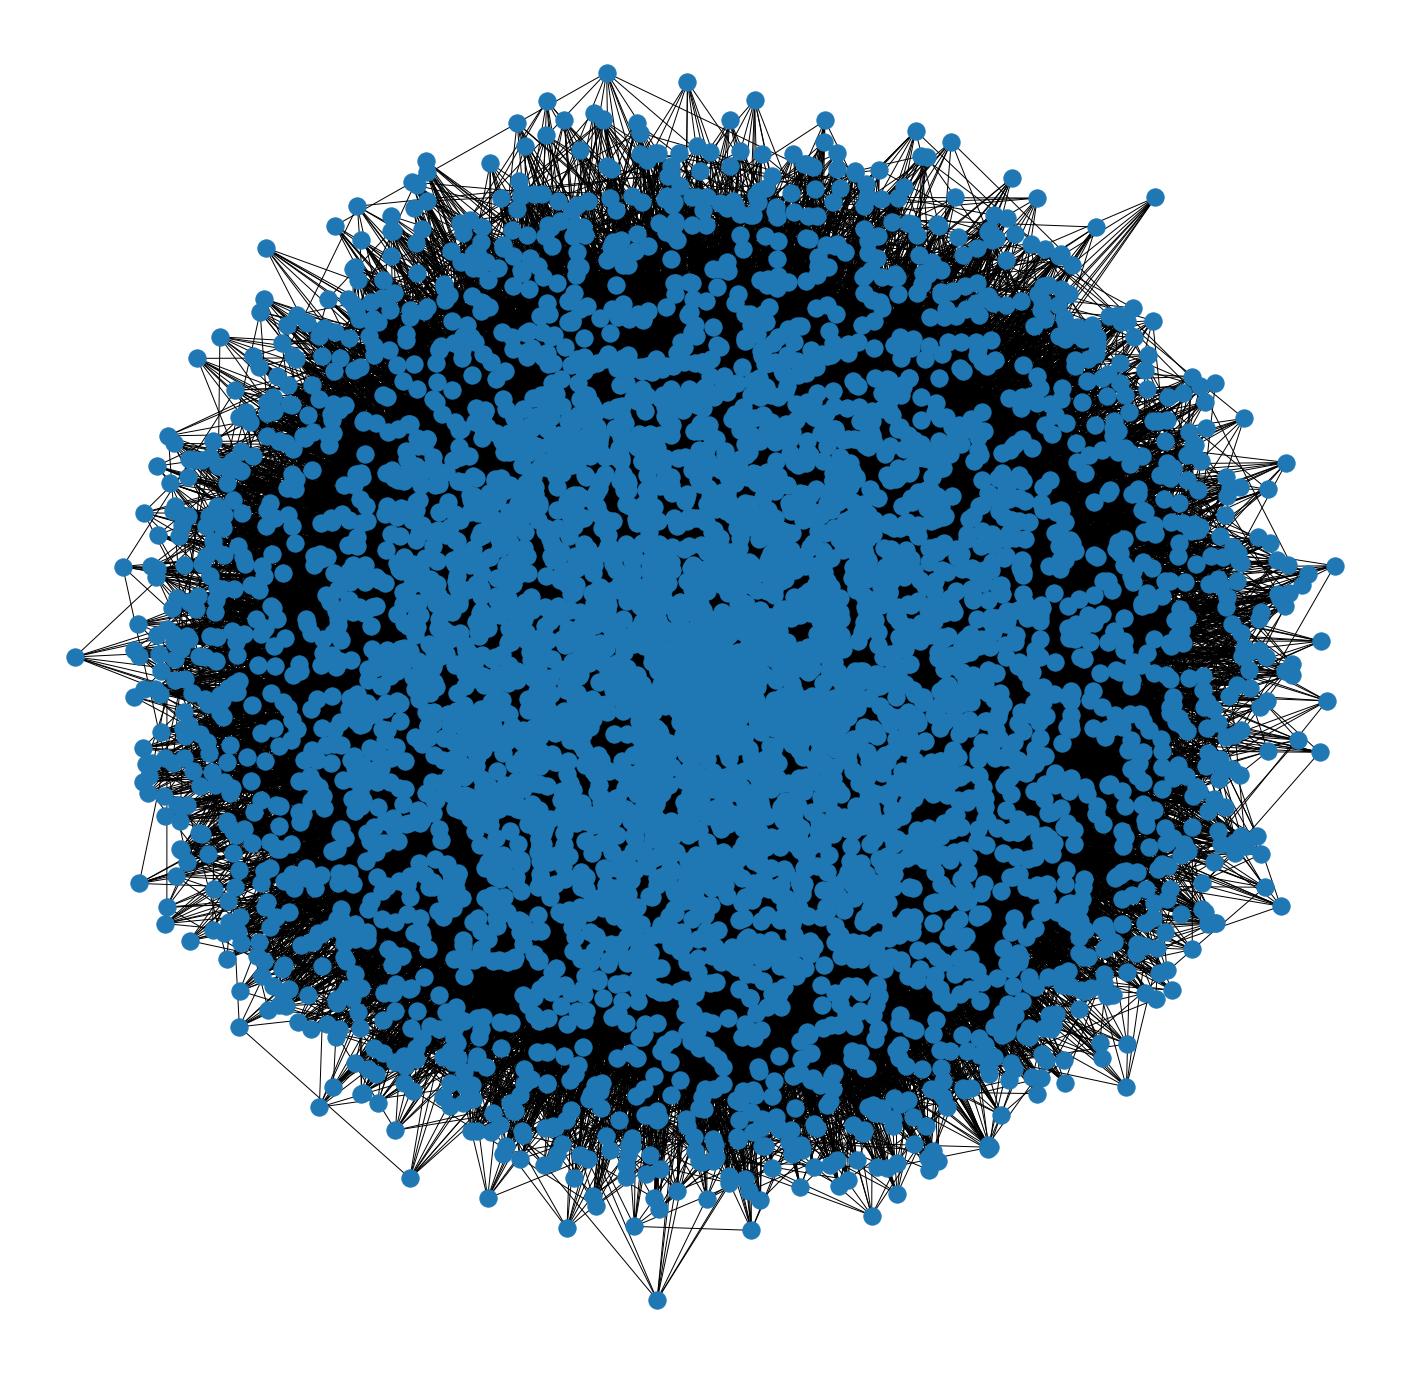

In [7]:
fig, ax = plt.subplots(figsize=(25,25))
nx.draw(G)

In [8]:
print(" NODOS :",len(G.nodes()))
print(" EDGES: ",len(G.edges()))
print(" Convenxo: ")
print(" Coeficiente de agrupamiento: ", nx.average_clustering(G))

dist_media, stdev = estimar_distancia_media(G)
print(" Distancia media: ", dist_media)
print(" Desviación estandar: ", stdev)

 NODOS : 5000
 EDGES:  74760
 Convenxo: 
 Coeficiente de agrupamiento:  0.026512181975084155
 Distancia media:  2.7425
 Desviación estandar:  0.4540856196798132


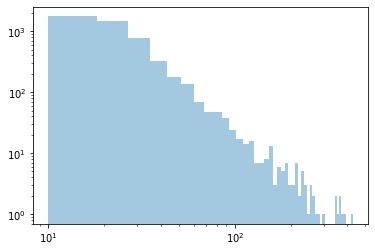

In [9]:
g = sns.distplot(list(dict(G.degree()).values()), kde=False)
g.set_xscale('log')
g.set_yscale('log')

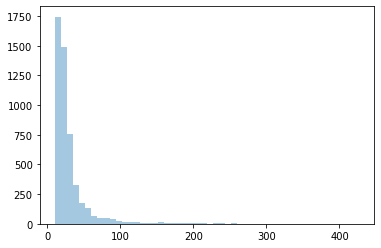

In [10]:
g = sns.distplot(list(dict(G.degree()).values()), kde=False)

In [29]:
?nx.extended_barabasi_albert_graph

Signature: nx.extended_barabasi_albert_graph(n, m, p, q, seed=None)
Docstring:
Returns an extended Barabási–Albert model graph.

An extended Barabási–Albert model graph is a random graph constructed
using preferential attachment. The extended model allows new edges,
rewired edges or new nodes. Based on the probabilities $p$ and $q$
with $p + q < 1$, the growing behavior of the graph is determined as:

1) With $p$ probability, $m$ new edges are added to the graph,
starting from randomly chosen existing nodes and attached preferentially at the other end.

2) With $q$ probability, $m$ existing edges are rewired
by randomly choosing an edge and rewiring one end to a preferentially chosen node.

3) With $(1 - p - q)$ probability, $m$ new nodes are added to the graph
with edges attached preferentially.

When $p = q = 0$, the model behaves just like the Barabási–Alber mo

Parameters
----------
n : int
    Number of nodes
m : int
    Number of edges with which a new node attaches to existing n

## Extended barabasi albert graph

- Un grafo del tipo extended Barabási-Albert es un grafo aleatorio construido usando adhesión preferencial. El modelo extendido permite nuevas aristas, reconexión de aristas o nuevos vertices. Basado en la probabilidad de $p$ y $q$ con $p + q < 1$, el comportamiento creciente del grafo esta determinado como sigue

- 1) Con probabilidad $p$, $m$ nuevas aristas son añadidas al grafo,a partir de nodos existentes elegidos al azar y conectados preferentemente en el otro extremo.

- 2) Con probabilidad $q$, $m$ aristas existentes son reconectadas al escoger aleatoriamente una arista y reconectando un extremo a un nodo elegido preferencialmente.

- 3) Con probabilidad $(1 - p - q)$, $m$ nuevos nodos son añadidos al grafo con aristas unidas preferecialmente

- n : int
    - Number of nodes
- m : int
    - Number of edges with which a new node attaches to existing nodes
- p : float
    - Probability value for adding an edge between existing nodes. p + q < 1
- q : float
    - Probability value of rewiring of existing edges. p + q < 1
- seed : integer, random_state, or None (default)
    - Indicator of random number generation state.

In [30]:
@py_random_state(4)
def extended_barabasi_albert_graph(n, m, p, q, seed=None):
    """Returns an extended Barabási–Albert model graph.

    An extended Barabási–Albert model graph is a random graph constructed
    using preferential attachment. The extended model allows new edges,
    rewired edges or new nodes. Based on the probabilities $p$ and $q$
    with $p + q < 1$, the growing behavior of the graph is determined as:

    1) With $p$ probability, $m$ new edges are added to the graph,
    starting from randomly chosen existing nodes and attached preferentially at the other end.

    2) With $q$ probability, $m$ existing edges are rewired
    by randomly choosing an edge and rewiring one end to a preferentially chosen node.

    3) With $(1 - p - q)$ probability, $m$ new nodes are added to the graph
    with edges attached preferentially.

    When $p = q = 0$, the model behaves just like the Barabási–Alber mo

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges with which a new node attaches to existing nodes
    p : float
        Probability value for adding an edge between existing nodes. p + q < 1
    q : float
        Probability value of rewiring of existing edges. p + q < 1
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n`` or ``1 >= p + q``

    References
    ----------
    .. [1] Albert, R., & Barabási, A. L. (2000)
       Topology of evolving networks: local events and universality
       Physical review letters, 85(24), 5234.
    """
    if m < 1 or m >= n:
        msg = "Extended Barabasi-Albert network needs m>=1 and m<n, m=%d, n=%d"
        raise nx.NetworkXError(msg % (m, n))
    if p + q >= 1:
        msg = "Extended Barabasi-Albert network needs p + q <= 1, p=%d, q=%d"
        raise nx.NetworkXError(msg % (p, q))

    # Add m initial nodes (m0 in barabasi-speak)
    G = empty_graph(m)

    # List of nodes to represent the preferential attachment random selection.
    # At the creation of the graph, all nodes are added to the list
    # so that even nodes that are not connected have a chance to get selected,
    # for rewiring and adding of edges.
    # With each new edge, nodes at the ends of the edge are added to the list.
    attachment_preference = []
    attachment_preference.extend(range(m))

    # Start adding the other n-m nodes. The first node is m.
    new_node = m
    while new_node < n:
        a_probability = seed.random()

        # Total number of edges of a Clique of all the nodes
        clique_degree = len(G) - 1
        clique_size = (len(G) * clique_degree) / 2

        # Adding m new edges, if there is room to add them
        if a_probability < p and G.size() <= clique_size - m:
            # Select the nodes where an edge can be added
            elligible_nodes = [nd for nd, deg in G.degree()
                               if deg < clique_degree]
            for i in range(m):
                # Choosing a random source node from elligible_nodes
                src_node = seed.choice(elligible_nodes)

                # Picking a possible node that is not 'src_node' or
                # neighbor with 'src_node', with preferential attachment
                prohibited_nodes = list(G[src_node])
                prohibited_nodes.append(src_node)
                # This will raise an exception if the sequence is empty
                dest_node = seed.choice([nd for nd in attachment_preference
                                           if nd not in prohibited_nodes])
                # Adding the new edge
                G.add_edge(src_node, dest_node)

                # Appending both nodes to add to their preferential attachment
                attachment_preference.append(src_node)
                attachment_preference.append(dest_node)

                # Adjusting the elligible nodes. Degree may be saturated.
                if G.degree(src_node) == clique_degree:
                    elligible_nodes.remove(src_node)
                if G.degree(dest_node) == clique_degree \
                        and dest_node in elligible_nodes:
                    elligible_nodes.remove(dest_node)

        # Rewiring m edges, if there are enough edges
        elif p <= a_probability < (p + q) and m <= G.size() < clique_size:
            # Selecting nodes that have at least 1 edge but that are not
            # fully connected to ALL other nodes (center of star).
            # These nodes are the pivot nodes of the edges to rewire
            elligible_nodes = [nd for nd, deg in G.degree()
                               if 0 < deg < clique_degree]
            for i in range(m):
                # Choosing a random source node
                node = seed.choice(elligible_nodes)

                # The available nodes do have a neighbor at least.
                neighbor_nodes = list(G[node])

                # Choosing the other end that will get dettached
                src_node = seed.choice(neighbor_nodes)

                # Picking a target node that is not 'node' or
                # neighbor with 'node', with preferential attachment
                neighbor_nodes.append(node)
                dest_node = seed.choice([nd for nd in attachment_preference
                                           if nd not in neighbor_nodes])
                # Rewire
                G.remove_edge(node, src_node)
                G.add_edge(node, dest_node)

                # Adjusting the preferential attachment list
                attachment_preference.remove(src_node)
                attachment_preference.append(dest_node)

                # Adjusting the elligible nodes.
                # nodes may be saturated or isolated.
                if G.degree(src_node) == 0 and src_node in elligible_nodes:
                    elligible_nodes.remove(src_node)
                if dest_node in elligible_nodes:
                    if G.degree(dest_node) == clique_degree:
                        elligible_nodes.remove(dest_node)
                else:
                    if G.degree(dest_node) == 1:
                        elligible_nodes.append(dest_node)

        # Adding new node with m edges
        else:
            # Select the edges' nodes by preferential attachment
            targets = _random_subset(attachment_preference, m, seed)
            G.add_edges_from(zip([new_node] * m, targets))

            # Add one node to the list for each new edge just created.
            attachment_preference.extend(targets)
            # The new node has m edges to it, plus itself: m + 1
            attachment_preference.extend([new_node] * (m + 1))
            new_node += 1
    return G

In [31]:
G = nx.extended_barabasi_albert_graph(1000, 10, .4, .1)

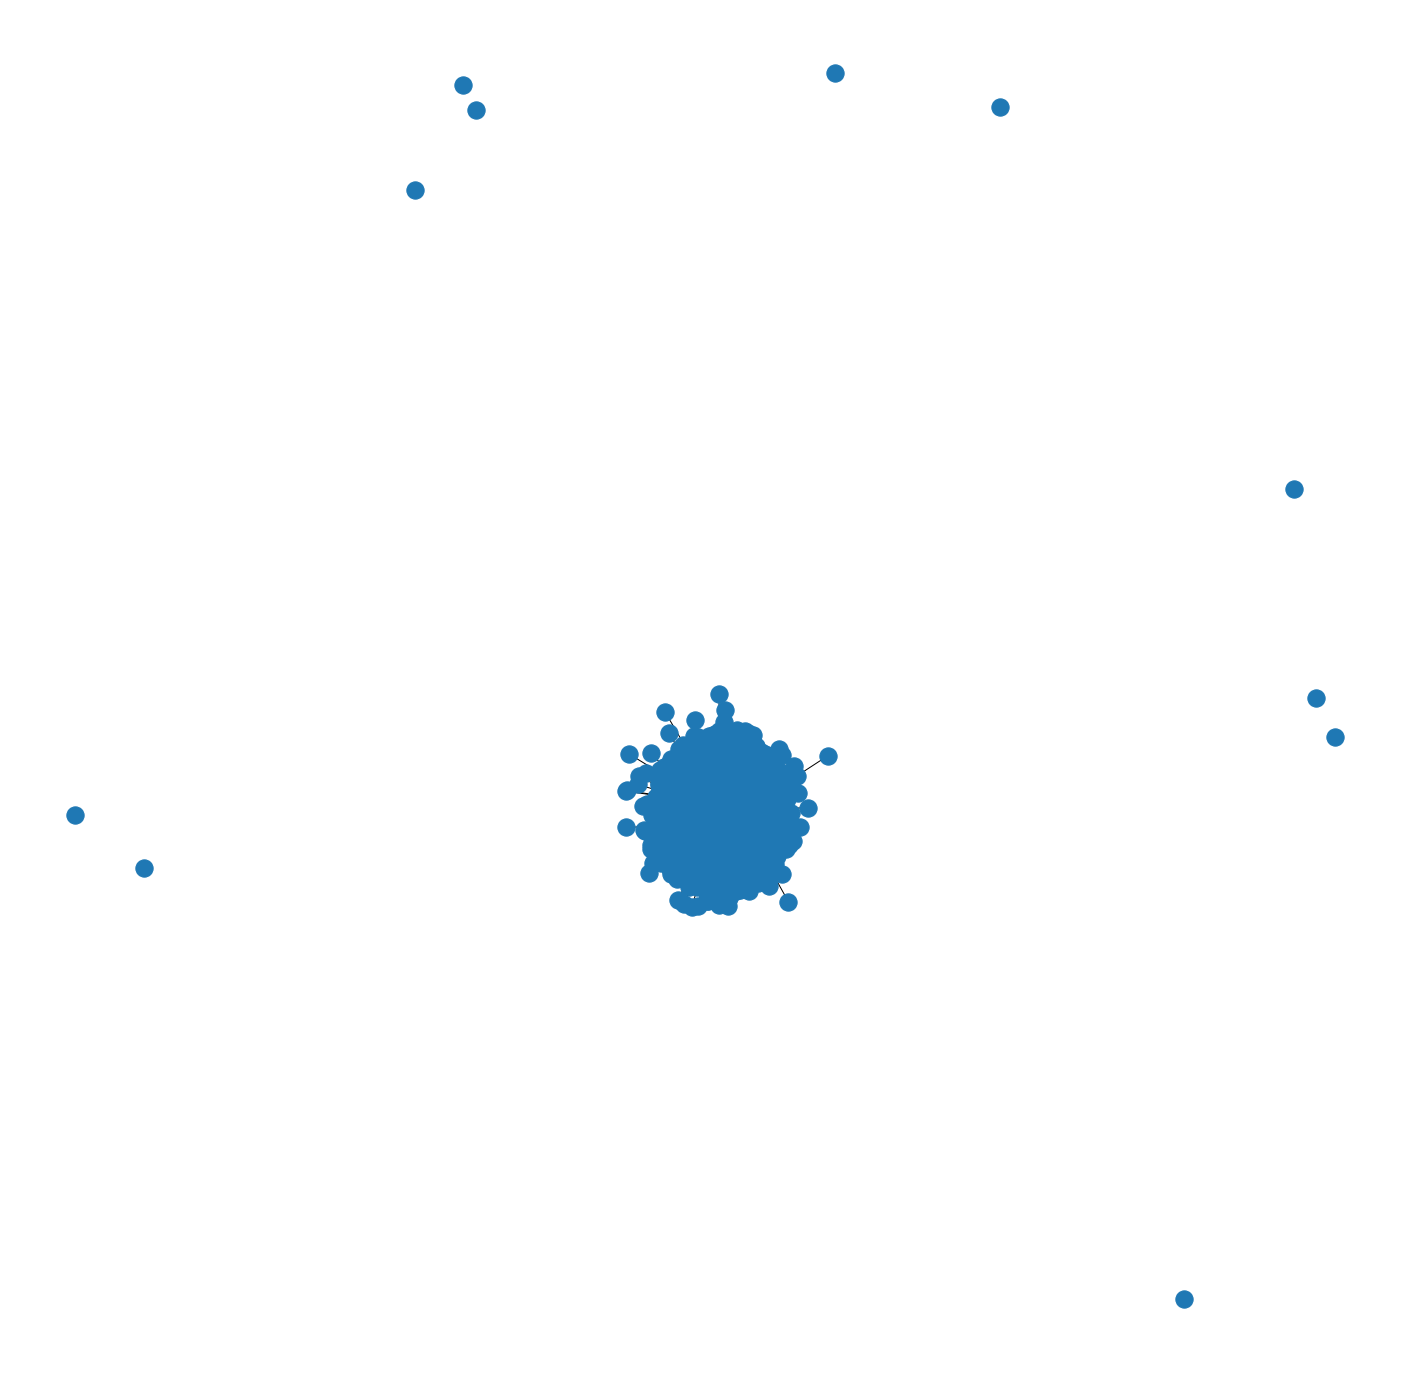

In [15]:
fig, ax = plt.subplots(figsize=(25,25))
nx.draw(G)

In [32]:
print(" NODOES :",len(G.nodes()))
print(" EDGES: ",len(G.edges()))
print(" Convenxo: ")
print(" Coeficiente de agrupamiento: ", nx.average_clustering(G))

dist_media, stdev = estimar_distancia_media(G)
print(" Distancia media: ", dist_media)
print(" Desviación estandar: ", stdev)

 NODOES : 1000
 EDGES:  17720
 Convenxo: 
 Coeficiente de agrupamiento:  0.1504403208357179
 Distancia media:  2.26
 Desviación estandar:  0.5314132102234569


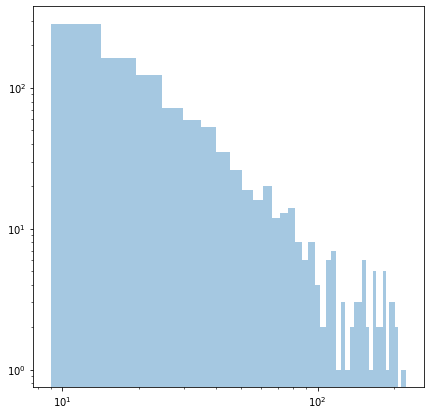

In [35]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.distplot(list(dict(G.degree()).values()), kde=False)